In [1]:
!pip install pennylane --upgrade
!pip install pennylane-qchem
!pip install xyz-py

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
from pennylane.templates.subroutines import UCCSD
from functools import partial
from matplotlib import pyplot as plt
import seaborn as sns
from xyz_py import save_xyz , load_xyz

sns.set_theme()

In [3]:
# @qml.template
# def unitary_block(param, wire):
#     qml.RY(param[0], wires=wire[0])
#     qml.RY(param[1], wires=wire[1])
#     qml.CNOT(wires = [wire[0], wire[1]])


def circuit_TTN(params, wires):
    
    global spin_config, num_qubits
    
    qml.BasisState(spin_config, wires=wires)
    
    # qml.broadcast(unitary_block(), 
    #                 wires = [0,1,2,3], 
    #                 pattern = "pyramid", 
    #                 parameters = params)
    
    for i in params:
        qml.RY(i[0], wires=0)
        qml.RY(i[1], wires=1)
        qml.CNOT(wires=[0,1])

    
        qml.RY(i[2], wires=2)
        qml.RY(i[3], wires=3)
        qml.CNOT(wires=[3,2])

    
        qml.RY(i[4], wires=4)
        qml.RY(i[5], wires=5)
        qml.CNOT(wires=[4,5])
        
        qml.RY(i[6], wires=6)
        qml.RY(i[7], wires=7)
        qml.CNOT(wires=[7,6])
                
        #######################
        qml.RY(i[8], wires=1)
        qml.RY(i[9], wires=2)
        
        
        qml.RY(i[10], wires=5)
        qml.RY(i[11], wires=6)
        #######################
        
        qml.CNOT(wires=[1,2])
        qml.CNOT(wires=[6,5])
        
        
        qml.RY(i[12], wires=2)
        qml.RY(i[13], wires=5)
        
        qml.CNOT(wires=[2,5])
        
        qml.RY(i[14], wires=5)
        
###############
    qml.RY(params[0][0], wires=0).inv()
    qml.RY(params[0][1], wires=1).inv()
    qml.CNOT(wires=[0,1])

    
    qml.RY(params[0][2], wires=3).inv()
    qml.RY(params[0][3], wires=2).inv()
    qml.CNOT(wires=[3,2])

    
    qml.RY(params[0][4], wires=4).inv()
    qml.RY(params[0][5], wires=5).inv()
    qml.CNOT(wires=[4,5])
        
    qml.RY(params[0][6], wires=7).inv()
    qml.RY(params[0][7], wires=6).inv()
    qml.CNOT(wires=[7,6])
                
        #######################
    qml.RY(params[0][8], wires=1).inv()
    qml.RY(params[0][9], wires=2).inv()
        
        
    qml.RY(params[0][10], wires=5).inv()
    qml.RY(params[0][11], wires=6).inv()
        #######################
        
    qml.CNOT(wires=[1,2])
    qml.CNOT(wires=[6,5])
        
        
    qml.RY(params[0][12], wires=2).inv()
    qml.RY(params[0][13], wires=5).inv()
        
    qml.CNOT(wires=[2,5])
        
    qml.RY(params[0][14], wires=5).inv()
    #qml.RZ(params[2][2], wires=1)
    #qml.RZ(params[2][3], wires=2)
    

In [7]:
bond_length = np.linspace(0.75, 3, 15)
min_energy = []
iter_list = []


for d in bond_length:

    save_xyz('BeH2.xyz' , 
             labels= ['Be', 'H', 'H'] , 
             coords=[[0 ,0 ,0],[0,0,d],[0,0,-d]],
             verbose=False)
    
    geometry = 'BeH2.xyz'
    charge = 0
    multiplicity = 1
    basis_set = 'sto-3g'
    name = 'BeH2'
    electrons = 4

    symbols, coordinates = qchem.read_structure(geometry)

    H, num_qubits = qchem.molecular_hamiltonian(
        symbols,
        coordinates,
        charge=charge,
        mult=multiplicity,
        basis=basis_set,
        active_electrons=4,
        active_orbitals=4,
        mapping='jordan_wigner'
    )

    dev = qml.device('default.qubit', wires=num_qubits)
    spin_config = qchem.hf_state(electrons, num_qubits)

    cost_fn_TTN = qml.ExpvalCost(circuit_TTN, H, dev)

    opt = qml.GradientDescentOptimizer(stepsize=0.4)

    # params = np.random.random([3])
    num_layers=5
    params = np.random.normal(0, np.pi, [num_layers,15])

    max_iters = 1000
    conv_tol = 1e-04

    for iter in range(max_iters):
        params, prev_energy = opt.step_and_cost(cost_fn_TTN, params)
        energy = cost_fn_TTN(params)
        conv = np.abs(energy - prev_energy)
        print(".",end='')

        if (iter == max_iters-1):
            iter_list.append(iter+1)
            min_energy.append(energy)
            print(f"\nBond length: {d}    |   Energy: {energy}    |   Iterations used: {iter+1}")

        elif (conv <= conv_tol):
            iter_list.append(iter+1)
            min_energy.append(energy)
            print(f"\nBond length: {d}    |   Energy: {energy}    |   Iterations used: {iter+1}")
            break



............................................................................................................................
Bond length: 0.75    |   Energy: -15.005156325374513    |   Iterations used: 124
.............................................................................................................................................................................................
Bond length: 0.9107142857142857    |   Energy: -15.352019281321777    |   Iterations used: 189
...........................................................................................................................................................................
Bond length: 1.0714285714285714    |   Energy: -15.503999752525386    |   Iterations used: 171
.......................................................................................
Bond length: 1.2321428571428572    |   Energy: -15.555673118726878    |   Iterations used: 87
............................................................

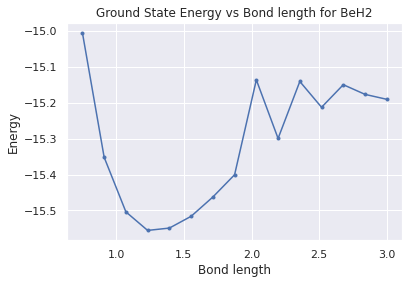

In [8]:
plt.plot(bond_length, min_energy,'.-')
plt.xlabel('Bond length')
plt.ylabel('Energy')
plt.title('Ground State Energy vs Bond length for BeH2')
plt.show()

In [9]:
with open("BeH2_bond_length_vs_energy_v4.csv", "ab") as f: 
    np.savetxt(f, np.transpose(np.array([bond_length, min_energy])),  delimiter=",", fmt="%f")

NameError: name 'np' is not defined